In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.odr import Model, Data, RealData, ODR
from scipy import stats

In [2]:
palette = sns.color_palette(palette='Paired')
from matplotlib.patches import Patch
handles = [Patch(facecolor=palette[4], label = 'BLOOD'), 
          Patch(facecolor=palette[0], label = 'KIDNEY'),
          Patch(facecolor=palette[2], label = 'LUNG'),
          Patch(facecolor=palette[6], label = 'LIVER'), 
          Patch(facecolor=palette[-4], label = 'all')]

In [3]:
bct = pd.read_excel('~/group/data/pheno/ukb21942_pheno_counts.xlsx', sheet_name='blood_count')
bchem = pd.read_excel('~/group/data/pheno/ukb21942_pheno_counts.xlsx', sheet_name='blood_biochemistry')
sp = pd.read_excel('~/group/data/pheno/ukb21942_pheno_counts.xlsx', sheet_name='spirometry')
data_d = '~/data/1_Single_Cell_PRS/2_cV2F'

In [4]:
tissue = ['BLOOD', 'LIVER', 'LUNG', 'KIDNEY', 'all']
trait = pd.read_csv(f'{data_d}/pheno_tissue.txt', header=None)[0].tolist()

trait_type_dict = {'INI30120' : 'Blood Count', 'INI20030780': 'Blood Biochemistry', 'INI50030700': 'Blood Biochemistry', 'INI1003063': 'Spirometry', }
trait_count_dict = trait_type_dict = {'INI30120' : bct, 'INI20030780': bchem, 'INI50030700': bchem, 'INI1003063': sp}

In [5]:
eur_data_d = f'{data_d}/mvp_eur_0.9_0.01/406k_geno_v2_UKB_18PCs/fit_w_val/'
afr_data_d = f'{data_d}/mvp_afr_0.9_0.01/20231221/406k_geno_v2_UKB_18PCs/fit_w_val/'
base_d = f'{data_d}/baselines/406k_geno_v2_UKB_18PCs/fit_w_val/'

In [6]:
tissue_trait_dict = {'INI30120' : 'BLOOD', 'INI20030780': 'LIVER', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI10030620': 'KIDNEY'}
reversed_dict = {value: key for key, value in tissue_trait_dict.items()}

In [7]:
df_afr_evals = []
for ti in tissue:
    for tr in trait:
        if tr == 'INI20030780':
            df = pd.read_csv(afr_data_d +ti + '/' + tr + '/exclude_APOE/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
        else:
        #print(data_d + ti + '/' + tr + '/')
            df = pd.read_csv(afr_data_d + ti + '/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
        df['Tissue'] = [ti] * len(df)
        df['Trait Category'] = [trait_type_dict[tr]] * len(df)
        df.replace(np.nan, 'All', inplace=True)
        df = df.merge(trait_count_dict[tr], left_on='#response', right_on='#GBE_ID')
        df_afr_evals.append(df)

In [8]:
df_afr_full = pd.concat(df_afr_evals)
df_afr_full = df_afr_full[df_afr_full['split'] == 'test']
df_afr_full = df_afr_full[['#response', 'eval', 'l_eval', 'u_eval', 'P', 'n', 'population', 'model', 'Tissue']]
df_afr_full['Source Cohort for Fine-mapped Variants'] = 'MVP_AFR'

In [9]:
df_eur_evals = []
for ti in tissue:
    for tr in trait:
        df = pd.read_csv(eur_data_d + ti + '/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
        df['Tissue'] = [ti] * len(df)
        df['Trait Category'] = [trait_type_dict[tr]] * len(df)
        df.replace(np.nan, 'All', inplace=True)
        df = df.merge(trait_count_dict[tr], left_on='#response', right_on='#GBE_ID')
        df_eur_evals.append(df)

In [10]:
df_eur_full = pd.concat(df_eur_evals)
df_eur_full = df_eur_full[df_eur_full['split'] == 'test']
df_eur_full = df_eur_full[['#response', 'eval', 'l_eval', 'u_eval', 'P', 'n', 'population', 'model', 'Tissue']]
df_eur_full['Source Cohort for Fine-mapped Variants'] = 'MVP_EUR'

In [11]:
df_base = []
for tr in trait:
    if tr == 'INI20030780':
        df = pd.read_csv(base_d + '/' + tr + '/exclude_APOE/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
    else:
        #print(data_d + ti + '/' + tr + '/')
        df = pd.read_csv(base_d + '/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip',)
    df['Trait Category'] = [trait_type_dict[tr]] * len(df)
    df.replace(np.nan, 'All', inplace=True)
    df = df.merge(trait_count_dict[tr], left_on='#response', right_on='#GBE_ID')
    df_base.append(df)

In [12]:
df_base_full = pd.concat(df_base)
df_base_full = df_base_full[df_base_full['split'] == 'test']
df_base_full = df_base_full[['#response', 'eval', 'l_eval', 'u_eval', 'P', 'n', 'population', 'model']]

In [13]:
pgs_full = pd.concat([df_afr_full, df_eur_full, df_base_full])
pgs_full = pgs_full[pgs_full['population'] != 'All']

In [14]:
filtered_base = df_base_full[(df_base_full['model'] == 'PGS')]
filtered_eur = df_eur_full[(df_eur_full['model'] == 'PGS')]
filtered_afr = df_afr_full[(df_afr_full['model'] == 'PGS')]

In [15]:
afr_eval = filtered_afr[filtered_afr['population'] == 'Afr']
afr_eval['index'] = afr_eval['#response'] +'_' +  afr_eval['Tissue']
afr_eval = afr_eval[afr_eval['index'].isin(['INI30120_BLOOD', 'INI20030780_LIVER', 'INI1003063_LUNG', 'INI50030700_KIDNEY'])]

/tmp/ipykernel_249907/2764685702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afr_eval['index'] = afr_eval['#response'] +'_' +  afr_eval['Tissue']


In [16]:
base_eur_eval = filtered_base[filtered_base['population'] == 'WB']
base_afr_eval = filtered_base[filtered_base['population'] == 'Afr']

In [17]:
eur_eval = filtered_eur[filtered_eur['population'] == 'Afr']
eur_eval['index'] = eur_eval['#response'] +'_' +  eur_eval['Tissue']
eur_eval = eur_eval[eur_eval['index'].isin(['INI30120_BLOOD', 'INI20030780_LIVER', 'INI1003063_LUNG', 'INI50030700_KIDNEY'])]

/tmp/ipykernel_249907/3550828774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eur_eval['index'] = eur_eval['#response'] +'_' +  eur_eval['Tissue']


In [18]:
afr_improv = base_afr_eval.iloc[:, :10].merge(afr_eval.iloc[:, :8], on=['#response', 'population', 'n']).rename(columns={'eval_x': 'eval_base', 'eval_y': 'eval_afr',
                                                                                                                                             'l_eval_x': 'l_eval_base', 'l_eval_y': 'l_eval_afr',
                                                                                                                                             'u_eval_x': 'u_eval_base', 'u_eval_y': 'u_eval_afr',
                                                                                                                                             'P_x': 'P_base', 'P_y': 'P_afr'})

In [19]:
afr = afr_improv.merge(eur_eval.iloc[:, :8], on=['#response', 'population', 'n']).rename(columns={'eval': 'eval_eur',
                                                                                                                'l_eval': 'l_eval_eur',
                                                                                                                'u_eval': 'u_eval_eur',
                                                                                                                'P': 'P_eur'})
afr = afr.set_index('#response')

In [21]:
def linear_model(beta, x):
    return beta[0] * x 

In [22]:
se_afr = afr['eval_afr'] - afr['l_eval_afr']
se_eur = afr['eval_eur'] - afr['l_eval_eur']
se_base = afr['eval_base'] - afr['l_eval_base']
se_diff = np.sqrt(np.square(se_afr) + np.square(se_base))
se_diff2 = np.sqrt(np.square(se_eur) + np.square(se_base))
x = afr['eval_base']
y = afr['eval_afr'] - afr['eval_base']
y2 = afr['eval_eur'] - afr['eval_base']
x_err = se_base


model = Model(linear_model)
data = RealData(x, y, sx=x_err, sy=se_diff)

odr = ODR(data, model, beta0=[1.0])  # Initial guess for parameters [a, b]
result = odr.run()
result.pprint()

Beta: [0.13134778]
Beta Std Error: [0.05013509]
Beta Covariance: [[0.25326155]]
Residual Variance: 0.009924630603791515
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Sum of squares convergence


In [23]:
df = len(x) - 1  # equivalently, degree of freedom (n_sample - n_param)
beta_0 = 1  # test if slope is significantly different from zero
t_stat = (result.beta[0] - beta_0) / (result.sd_beta[0]/df)  # t statistic for the slope parameter
p_val = stats.t.sf(np.abs(t_stat), df) * 2
print('Recovered equation: y={:3.3f}x, t={:3.3f}, p={:f}'.format(result.beta[0], t_stat, p_val))

Recovered equation: y=0.131x, t=-51.979, p=0.000016


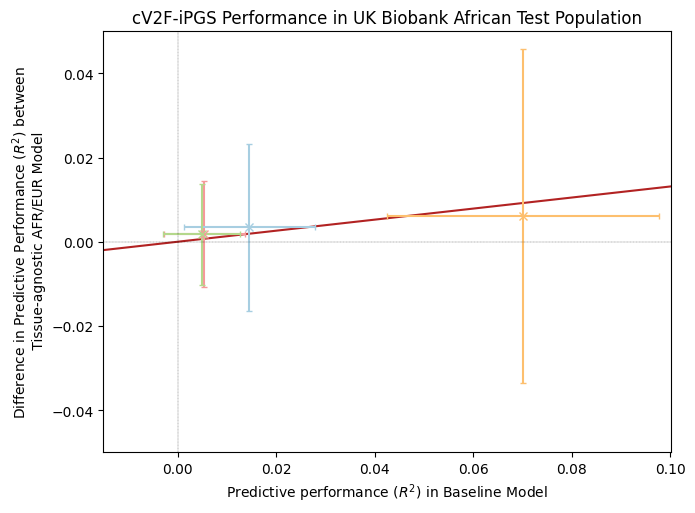

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots()
fig.tight_layout()

# ================= AFR regression line =================
slope = result.beta[0]
x_fit = np.linspace(min(x)-0.02, max(x)+0.03, 100)
y_fit = slope * x_fit
ax.plot(
    x_fit, y_fit,
    label='AFR ODR Regression: y=0.131x, p=1.6 x $10^{-5}$', color='firebrick'
)

# ================= Shared color palette =================
palette = ["#f6999a", "#a7cee1", "#b4d88c", "#fdbf6e"]

# --- AFR model (x markers, dotted errorbars) ---
for xi, yi, xe, ye, c in zip(x, y, se_base, se_diff, palette):
    er1 = ax.errorbar(
        xi, yi, xerr=xe, yerr=ye,
        fmt='x', capsize=2, color=c
    )

afr_proxy = mlines.Line2D(
    [], [], color='black', marker='x', linestyle=':',
    label='AFR model'
)
# ================= Axes & labels =================
ax.axhline(y=0, linestyle='--', color='black', linewidth=0.2)
ax.axvline(x=0, linestyle='--', color='black', linewidth=0.2)

ax.set_xlabel(r'Predictive performance ($R^{2}$) in Baseline Model')
ax.set_ylabel('Difference in Predictive Performance ($R^{2}$) between\n Tissue-agnostic AFR/EUR Model')
ax.set_title('cV2F-iPGS Performance in UK Biobank African Test Population')

ax.set_xlim([min(x)-0.02, max(x)+0.03])
ax.set_ylim([-0.05, 0.05])


# ================= Save =================
# ax.figure.savefig('improve_combined_agnostic.pdf', bbox_inches='tight')
plt.show()
